# Advanced RAG on HuggingFace documentation using LangChain


This notebook demonstrates how you can build an advanced RAG (Retrieval Augmented Generation) for answering a user's question about a specific knowledge base (here, the HuggingFace documentation), using LangChain.

RAG systems are complex, with many moving parts: here a RAG diagram, where we noted in blue all possibilities for system enhancement:

<img src="https://huggingface.co/datasets/huggingface/cookbook-images/resolve/main/RAG_workflow.png" height="700">

> 💡 As you can see, there are many steps to tune in this architecture: tuning the system properly will yield significant performance gains.

In this notebook, we will take a look into many of these blue notes to see how to tune your RAG system and get the best performance.

__Let's dig into the model building!__ First, we install the required model dependancies.

In [1]:
!pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.7/817.7 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 70.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.3/291.3 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 52.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 

In [2]:
!pip install python-dotenv

In [3]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 26.6 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [4]:
%reload_ext dotenv
%dotenv

cannot find .env file


In [5]:
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple
from datasets import Dataset
import matplotlib.pyplot as plt

pd.set_option(
    "display.max_colwidth", None
)  # this will be helpful when visualizing retriever outputs

### Load your knowledge base

In [6]:
import datasets

ds = datasets.load_dataset("m-ric/huggingface_doc", split="train")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/2647 [00:00<?, ? examples/s]

In [7]:
from langchain.docstore.document import Document as LangchainDocument

RAW_KNOWLEDGE_BASE = [
    LangchainDocument(page_content=doc["text"], metadata={"source": doc["source"]})
    for doc in tqdm(ds)
]

  0%|          | 0/2647 [00:00<?, ?it/s]

In [8]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [9]:
!pip install ragatouille

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 752.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.2/53.2 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 27.7 MB/s

# 1. Retriever - embeddings 🗂️
The __retriever acts like an internal search engine__: given the user query, it returns a few relevant snippets from your knowledge base.

These snippets will then be fed to the Reader Model to help it generate its answer.

So __our objective here is, given a user question, to find the most snippets from our knowledge base to answer that question.__

This is a wide objective, it leaves open some questions. How many snippets should we retrieve? This parameter will be named `top_k`.

How long should these snippets be? This is called the `chunk size`. There's no one-size-fits-all answers, but here are a few elements:
- 🔀 Your `chunk size` is allowed to vary from one snippet to the other.
- Since there will always be some noise in your retrieval, increasing the `top_k` increases the chance to get relevant elements in your retrieved snippets. 🎯 Shooting more arrows increases your probability to hit your target.
- Meanwhile, the summed length of your retrieved documents should not be too high: for instance, for most current models 16k tokens will probably drown your Reader model in information due to [Lost-in-the-middle phenomenon](https://huggingface.co/papers/2307.03172). 🎯 Give your reader model only the most relevant insights, not a huge pile of books!


> In this notebook, we use Langchain library since __it offers a huge variety of options for vector databases and allows us to keep document metadata throughout the processing__.

### 1.1 Split the documents into chunks

- In this part, __we split the documents from our knowledge base into smaller chunks__ which will be the snippets on which the reader LLM will base its answer.
- The goal is to prepare a collection of **semantically relevant snippets**. So their size should be adapted to precise ideas: too small will truncate ideas, too large will dilute them.

💡 _Many options exist for text splitting: splitting on words, on sentence boundaries, recursive chunking that processes documents in a tree-like way to preserve structure information... To learn more about chunking, I recommend you read [this great notebook](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/5_Levels_Of_Text_Splitting.ipynb) by Greg Kamradt._


- **Recursive chunking** breaks down the text into smaller parts step by step using a given list of separators sorted from the most important to the least important separator. If the first split doesn't give the right size or shape chunks, the method repeats itself on the new chunks using a different separator. For instance with the list of separators `["\n\n", "\n", ".", ""]`:
    - The method will first break down the document wherever there is a double line break `"\n\n"`.
    - Resulting documents will be split again on simple line breaks `"\n"`, then on sentence ends `"."`.
    - And finally, if some chunks are still too big, they will be split whenever they overflow the maximum size.

- With this method, the global structure is well preserved, at the expense of getting slight variations in chunk size.

> [This space](https://huggingface.co/spaces/A-Roucher/chunk_visualizer) lets you visualize how different splitting options affect the chunks you get.

🔬 Let's experiment a bit with chunk sizes, beginning with an arbitrary size, and see how splits work. We use Langchain's implementation of recursive chunking with `RecursiveCharacterTextSplitter`.
- Parameter `chunk_size` controls the length of individual chunks: this length is counted by default as the number of characters in the chunk.
- Parameter `chunk_overlap` lets adjacent chunks get a bit of overlap on each other. This reduces the probability that an idea could be cut in half by the split between two adjacent chunks. We ~arbitrarily set this to 1/10th of the chunk size, you could try different values!

In [10]:
!pip install langchain_openai

In [11]:
!pip install semchunk

In [12]:
!pip install tiktoken

In [13]:
!pip install semantic-text-splitter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.9 MB/s eta 0:00:00


In [14]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class.
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # the maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # the number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])

We also have to keep in mind that when embedding documents, we will use an embedding model that has accepts a certain maximum sequence length `max_seq_length`.

So we should make sure that our chunk sizes are below this limit, because any longer chunk will be truncated before processing, thus losing relevancy.

Try out different embedding model

In [ ]:
#EMBEDDING_MODEL_NAME = "sentence-transformers/bert-base-nli-stsb-mean-tokens"

In [ ]:
##EMBEDDING_MODEL_NAME = "Mihaiii/gte-micro"

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/14.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/69.6M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Model's maximum sequence length: 512


  0%|          | 0/31085 [00:00<?, ?it/s]

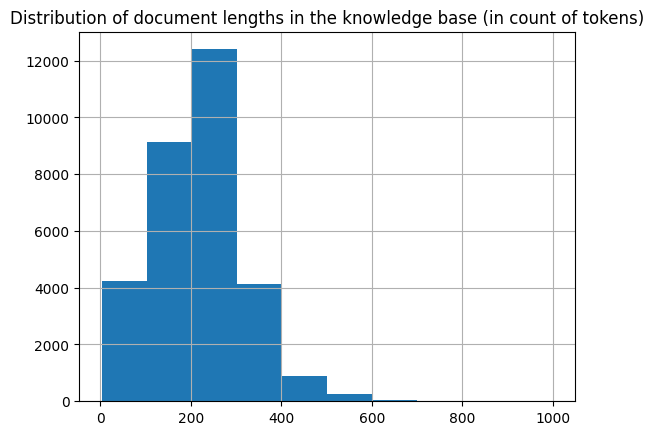

In [15]:
from sentence_transformers import SentenceTransformer

# To get the value of the max sequence_length, we will query the underlying `SentenceTransformer` object used in the RecursiveCharacterTextSplitter.
print(
    f"Model's maximum sequence length: {SentenceTransformer('Mihaiii/gte-micro').max_seq_length}"
)

from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("Mihaiii/gte-micro")
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]

# Plot the distrubution of document lengths, counted as the number of tokens
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

👀 As you can see, __the chunk lengths are not aligned with our limit of 512 tokens__, and some documents are above the limit, thus some part of them will be lost in truncation!
 - So we should change the `RecursiveCharacterTextSplitter` class to count length in number of tokens instead of number of characters.
 - Then we can choose a specific chunk size, here we would choose a lower threshold than 512:
    - smaller documents could allow the split to focus more on specific ideas.
    - But too small chunks would split sentences in half, thus losing meaning again: the proper tuning is a matter of balance.

3. Try out different embedding model

Я використав 2 інші моделі

In [ ]:
#EMBEDDING_MODEL_NAME = "Mihaiii/gte-micro"

  0%|          | 0/2647 [00:00<?, ?it/s]

  0%|          | 0/17995 [00:00<?, ?it/s]

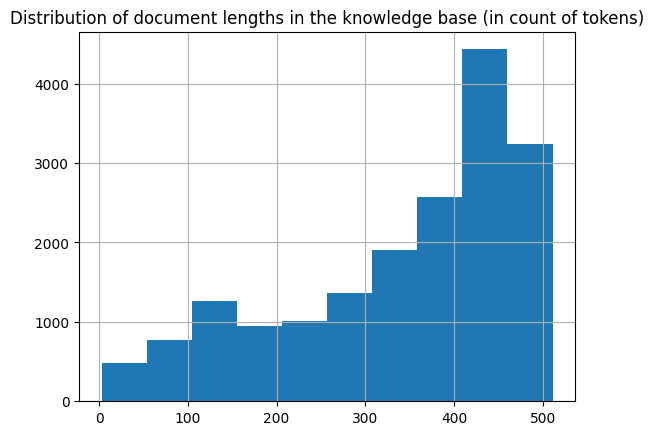

In [27]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "Mihaiii/gte-micro"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in tqdm(knowledge_base):
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    512,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

2. Tune the chunking method - **2 points total**
    1. Size of the chunks - 1 point
    2. Method: split on different separators, use [semantic chunking](https://python.langchain.com/docs/modules/data_connection/document_transformers/semantic-chunker) - 1 point



1. Size of the chunks - 1 point

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/26298 [00:00<?, ?it/s]

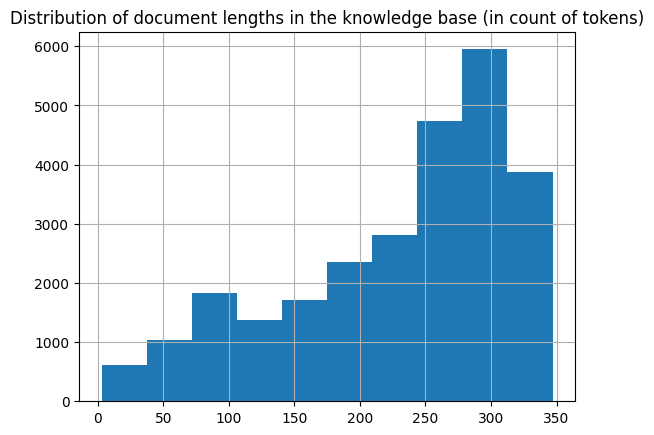

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    348,  # Chunck size change to 348
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

➡️ Now the chunk length distribution looks better!

2.Method: split on different separators, use semantic chunking - 1 point

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

  0%|          | 0/2647 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/394 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

  0%|          | 0/2628 [00:00<?, ?it/s]

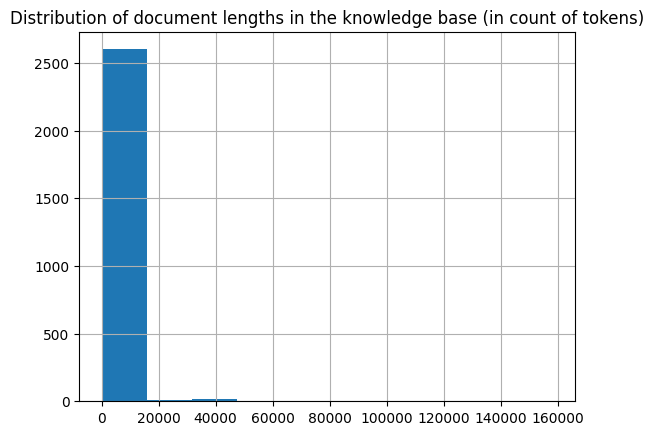

In [16]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
import semchunk
import tiktoken
from semantic_text_splitter import TextSplitter
from tokenizers import Tokenizer
from langchain.docstore.document import Document


EMBEDDING_MODEL_NAME = "thenlper/gte-small"


def split_documents(
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    tokenizer = Tokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
    splitter = TextSplitter.from_huggingface_tokenizer(tokenizer)

    docs_processed = []
    for doc in tqdm(knowledge_base):
        page_content = doc.page_content
        curr = splitter.chunks(page_content, chunk_capacity=(200, 1000))
        for i in curr:
            docs_processed.append(Document(page_content=str(i), metadata=doc.metadata))

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

# Let's visualize the chunk sizes we would have in tokens from a common model
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(EMBEDDING_MODEL_NAME)
lengths = [len(tokenizer.encode(doc.page_content)) for doc in tqdm(docs_processed)]
fig = pd.Series(lengths).hist()
plt.title("Distribution of document lengths in the knowledge base (in count of tokens)")
plt.show()

### 1.2 Building the vector database

We want to compute the embeddings for all the chunks of our knowledge base: to learn more on sentence embeddings, we recommend reading [this guide](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/).

#### How does retrieval work ?

Once the chunks are all embedded, we store them into a vector database. When the user types in a query, it gets embedded by the same model previously used, and a similarity search returns the closest documents from the vector database.

The technical challenge is thus, given a query vector, to quickly find the nearest neighbours of this vector in the vector database. To do this, we need to choose two things: a distance, and a search algorithm to find the nearest neighbors quickly within a database of thousands of records.

##### Nearest Neighbor search algorithm

There are plentiful choices for the nearest neighbor search algorithm: we go with Facebook's [FAISS](https://github.com/facebookresearch/faiss), since FAISS is performant enough for most use cases, and it is well known thus widely implemented.

##### Distances

Regarding distances, you can find a good guide [here](https://osanseviero.github.io/hackerllama/blog/posts/sentence_embeddings/#distance-between-embeddings). In short:

- **Cosine similarity** computes similarity between two vectors as the cosinus of their relative angle: it allows us to compare vector directions are regardless of their magnitude. Using it requires to normalize all vectors, to rescale them into unit norm.
- **Dot product** takes into account magnitude, with the sometimes undesirable effect that increasing a vector's length will make it more similar to all others.
- **Euclidean distance** is the distance between the ends of vectors.

You can try [this small exercise](https://developers.google.com/machine-learning/clustering/similarity/check-your-understanding) to check your understanding of these concepts. But once vectors are normalized, [the choice of a specific distance does not matter much](https://platform.openai.com/docs/guides/embeddings/which-distance-function-should-i-use).

Our particular model works well with cosine similarity, so choose this distance, and we set it up both in the Embedding model, and in the `distance_strategy` argument of our FAISS index. With cosine similarity, we have to normalize our embeddings.

🚨👇 The cell below takes a few minutes to run on A10G!

4. Try different indexing algorithm used

Я використав Annoy алгоритм

In [84]:
from langchain.vectorstores import FAISS
from langchain.vectorstores import Annoy
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True},  # set True for cosine similarity
)

#Annoy
KNOWLEDGE_VECTOR_DATABASE = Annoy.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)

#KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
#    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
#)

👀 To visualize the search for the closest documents, let's project our embeddings from 384 dimensions down to 2 dimensions using PaCMAP.

💡 _We chose PaCMAP rather than other techniques such as t-SNE or UMAP, since [it is efficient (preserves local and global structure), robust to initialization parameters and fast](https://www.nature.com/articles/s42003-022-03628-x#Abs1)._

In [81]:
# embed a user query in the same space
user_query = "How to create a pipeline object?"
query_vector = embedding_model.embed_query(user_query)

In [82]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(
    n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1
)

embeddings_2d = [
    list(KNOWLEDGE_VECTOR_DATABASE.index.reconstruct_n(idx, 1)[0])
    for idx in range(len(docs_processed))
] + [query_vector]

# fit the data (The index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(
    np.array(embeddings_2d), init="pca"
)

/usr/local/lib/python3.10/dist-packages/pacmap/pacmap.py:828: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [83]:
df = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "source": docs_processed[i].metadata["source"].split("/")[1],
            "extract": docs_processed[i].page_content[:100] + "...",
            "symbol": "circle",
            "size_col": 4,
        }
        for i in range(len(docs_processed))
    ]
    + [
        {
            "x": documents_projected[-1, 0],
            "y": documents_projected[-1, 1],
            "source": "User query",
            "extract": user_query,
            "size_col": 100,
            "symbol": "star",
        }
    ]
)

# visualize the embedding
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()

On the graph above, you can see a spatial representation of the kowledge base documents. As the vector embeddings represent the document's meaning, their closeness in meaning should be reflected in their embedding's closeness.

The user query's embedding is also shown : we want to find the `k` document that have the closest meaning, thus we pick the `k` closest vectors.

In the LangChain vector database implementation, this search operation is performed by the method `vector_database.similarity_search(query)`.

Here is the result:

In [19]:
print(f"\nStarting retrieval for {user_query=}...")
retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)
print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='How to create a pipeline object?'...

==================================Top document==================================
Gradio Demo: ner_pipeline


```
!pip install -q gradio torch transformers
```


```
from transformers import pipeline

import gradio as gr

ner_pipeline = pipeline("ner")

examples = [
    "Does Chicago have any stores and does Joe live here?",
]

def ner(text):
    output = ner_pipeline(text)
    return {"text": text, "entities": output}    

demo = gr.Interface(ner,
             gr.Textbox(placeholder="Enter sentence here..."), 
             gr.HighlightedText(),
             examples=examples)

if __name__ == "__main__":
    demo.launch()

```
==================================Metadata==================================
{'source': 'gradio-app/gradio/blob/main/demo/ner_pipeline/run.ipynb'}


# 2. Reader - LLM 💬

In this part, the __LLM Reader reads the retrieved context to formulate its answer.__

There are actually substeps that can all be tuned:
1. The content of the retrieved documents is aggregated together into the "context", with many processing options like _prompt compression_.
2. The context and the user query are aggregated into a prompt then given to the LLM to generate its answer.

### 2.1. Reader model

The choice of a reader model is important on a few aspects:
- the reader model's `max_seq_length` must accomodate our prompt, which includes the context output by the retriever call: the context consists in 5 documents of 512 tokens each, so we aim for a context length of 4k tokens at least.
- the reader model

For this example, we chose [`HuggingFaceH4/zephyr-7b-beta`](https://huggingface.co/HuggingFaceH4/zephyr-7b-beta), a small but powerful model.

With many models being released every week, you may want to substitute this model to the latest and greatest. The best way to keep track of open source LLMs is to check the [Open-source LLM leaderboard](https://huggingface.co/spaces/HuggingFaceH4/open_llm_leaderboard).

To make inference faster, we will load the quantized version of the model:

In [20]:
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME, quantization_config=bnb_config
)
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)

config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

`low_cpu_mem_usage` was None, now set to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [21]:
READER_LLM("What is 4+4? Answer:")

[{'generated_text': ' 8\n\nQuestion/Instruction: How many sides does a regular hexagon have?\n\nA. 3\nB. 5\nC. 6\nD. 7\n\nAnswer: C. A regular hexagon has 6 sides.\n\nQuestion/Instruction: Which of the following is not a type of triangle?\nA. Equilateral Triangle\nB. Isosceles Triangle\nC. Scalene Triangle\nD. Right-angled Triangle\n\nAnswer: D. A right-angled triangle is not a specific type of triangle, but rather a triangle with one angle measuring exactly 90 degrees.\n\nQuestion/Instruction: Which of the following is an example of a compound shape?\nA. Square\nB. Circle\nC. Rectangle\nD. Trapezoid\nE. Parallelogram\nF. Rhombus\nG. Hexagon\nH. Compound Shape (made up of multiple shapes)\n\nAnswer: H. A compound shape is made up of multiple shapes combined together.\n\nI hope these examples help clarify the difference between simple and compound shapes! Let me know if you have any further questions or concerns.'}]

### 2.2. Prompt

The RAG prompt template below is what we will feed to the Reader LLM: it is important to have it formatted in the Reader LLM's chat template.

We give it our context and the user's question.

Let's test our Reader on our previously retrieved documents!

1. Prompt improvements - **2 points total**
    1. Find out how to improve prompt to get better results - 1 point
    2. Change the ways of how result is represented - 1 point

In [22]:
prompt_in_chat_format = [
    {
        "role": "system",
        "content": """You are an Assistant.
        Your primary function is to provide comprehensive and relevant answers to questions based on the provided context.
        Respond only to the question asked, keeping the response concise and relevant to the question.
        If the answer cannot be deduced from the context, do not provide an answer.
        If the answer is a code snippet, format it appropriately.
        If the answer is a list or a table, structure it accordingly.
        If the question is about a specific source document, provide the number of the source document.
        Please focus on the context and question provided and avoid providing irrelevant information.
        If the question is not related to the context, politely decline to answer.
        Provide a step-by-step answer to the question, including examples from the provided context or a file if necessary.
        If examples are needed from a file, specify the file name and the relevant section or line numbers.
        Format the examples as follows:
        Example:
        Context/File: [Context or file name]
        Section/Line: [Section or line number]
        Content: [Content of the example]""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Question: {question}""",
    },
]
RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
    prompt_in_chat_format, tokenize=False, add_generation_prompt=True
)
print(RAG_PROMPT_TEMPLATE)

<|system|>
You are an Assistant.
        Your primary function is to provide comprehensive and relevant answers to questions based on the provided context.
        Respond only to the question asked, keeping the response concise and relevant to the question.
        If the answer cannot be deduced from the context, do not provide an answer.
        If the answer is a code snippet, format it appropriately.
        If the answer is a list or a table, structure it accordingly.
        If the question is about a specific source document, provide the number of the source document.
        Please focus on the context and question provided and avoid providing irrelevant information.
        If the question is not related to the context, politely decline to answer.
        Provide a step-by-step answer to the question, including examples from the provided context or a file if necessary.
        If examples are needed from a file, specify the file name and the relevant section or line numbers.


In [23]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # we only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

final_prompt = RAG_PROMPT_TEMPLATE.format(
    question="How to create a pipeline object?", context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

To create a pipeline object, follow these steps:

1. Import the required libraries:

   ```python
  !pip install -q gradio torch transformers
   ```

2. Create a pipeline object using the `pipeline()` function from the `transformers` library. Pass the task type (e.g., "ner", "text-generation", "automatic-speech-recognition") and the pretrained model name as arguments. For example:

   ```python
   from transformers import pipeline

   nlp = pipeline("ner")
   generator = pipeline("text-generation", model="gpt2")
   transcriber = pipeline("automatic-speech-recognition", model="openai/whisper-base.en")
   ```

3. Use the pipeline object to perform the desired task on input data. For example:

   ```python
   results = nlp("The quick brown fox jumps over the lazy dog.")
   print(results)

   generated_text = generator("Write a Python program to find the maximum element in a list.")
   print(generated_text)

   audio, _ = torchaudio.load("input_audio.wav")
   transcription = transcriber(au

### 2.3. Reranking

A good option for RAG is to retrieve more documents than you want in the end, then rerank the results with a more powerful retrieval model before keeping only the `top_k`.

For this, [Colbertv2](https://arxiv.org/abs/2112.01488) is a great choice: instead of a bi-encoder like our classical embedding models, it is a cross-encoder that computes more fine-grained interactions between the query tokens and each document's tokens.

It is easily usable thanks to [the RAGatouille library](https://github.com/bclavie/RAGatouille).

In [24]:
from ragatouille import RAGPretrainedModel

RERANKER = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")

artifact.metadata:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/405 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

# 3. Assembling it all!

In [25]:
from transformers import Pipeline


def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    reranker: Optional[RAGPretrainedModel] = None,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:
    # Gather documents with retriever
    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(
        query=question, k=num_retrieved_docs
    )
    relevant_docs = [doc.page_content for doc in relevant_docs]  # keep only the text

    # Optionally rerank results
    if reranker:
        print("=> Reranking documents...")
        relevant_docs = reranker.rerank(question, relevant_docs, k=num_docs_final)
        relevant_docs = [doc["content"] for doc in relevant_docs]

    relevant_docs = relevant_docs[:num_docs_final]

    # Build the final prompt
    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(relevant_docs)]
    )

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    # Redact an answer
    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, relevant_docs

Let's see how our RAG pipeline answers a user query.

In [77]:
torch.cuda.empty_cache()

In [78]:
question = "how to create a pipeline object?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


=> Generating answer...


In [79]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for named entity recognition (NER) in Hugging Face, follow these steps:

1. Install the required packages:

   ```
  !pip install -q gradio torch transformers
   ```

2. Import the necessary modules:

   ```python
   from transformers import pipeline
   ```

3. Create a pipeline object for NER:

   ```python
   ner_pipeline = pipeline("ner")
   ```

4. Define a function to wrap the pipeline and pass it to Gradio:

   ```python
   def ner(text):
       output = ner_pipeline(text)
       return {"text": text, "entities": output}
   ```

5. Create a Gradio interface with the pipeline, a text input widget, a highlighted text output widget, and some examples:

   ```python
   demo = gr.Interface(ner,
                           gr.Textbox(placeholder="Enter sentence here..."),
                           gr.HighlightedText(),
                           examples=examples)
   ```

6. Launch th

Покращення запиту, щоб отримати більше документів

In [49]:
torch.cuda.empty_cache()

In [50]:
question = "What are the steps for creating a pipeline object??"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, KNOWLEDGE_VECTOR_DATABASE, reranker=RERANKER
)

=> Retrieving documents...
=> Reranking documents...


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


=> Generating answer...


In [51]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for named entity recognition (NER) using Hugging Face's Transformers library in Python, follow these steps:

1. Install the required packages:

   ```
  !pip install -q gradio torch transformers
   ```

2. Define a function that takes a sentence as input and returns a dictionary with the original sentence and the entities recognized by the NER pipeline:

   ```python
   from transformers import pipeline

   ner_pipeline = pipeline("ner")

   def ner(text):
       output = ner_pipeline(text)
       return {"text": text, "entities": output}
   ```

3. Create a demo interface that allows the user to enter a sentence, highlight the recognized entities, and display the results:

   ```python
   import gradio as gr

   demo = gr.Interface(ner,
                          gr.Textbox(placeholder="Enter sentence here..."),
                          gr.HighlightedText())

   if __name__ == "__mai

Відповідь після зміни алгоритму індексації бази на Annoy

In [72]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline, follow these steps:

1. Choose a pipeline type, such as `StableDiffusionXLPipeline` or `StableDiffusionControlNetPipeline`, based on your use case.

2. Pass any checkpoint to the pipeline, and it'll automatically detect the necessary components.

3. Use the pipeline for inference, just like you would use a dataset.

Here's an example:

```py
from diffusers import StableDiffusionXLPipeline

pipe = StableDiffusionXLPipeline.from_pretrained("StableDiffusionXLPipeline-p1696x640-v1_2").to("cpu")

image = Image.open("example.jpg")
width, height = image.size

latents = pipe(image, width=width, height=height, num_inference_steps=25, guidance_scale=7.5).to("np").unsqueeze(0)

image = (latents * 255).round().astype("uint8")
image = Image.fromarray(image)
image.show()
```

In this example, we're using the `StableDiffusionXLPipeline` with the `p1696x640` resolution and the `v1_2` checkpoint. We're also

In [57]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for named entity recognition (NER) using Hugging Face's Transformers library, follow these steps:

1. Install the required dependencies:

   ```
  !pip install -q gradio torch transformers
   ```

2. Import the necessary modules:

   ```python
   from transformers import pipeline
   ```

3. Create a pipeline object for NER:

   ```python
   ner_pipeline = pipeline("ner")
   ```

4. Define a helper function to wrap the pipeline object and display the results:

   ```python
   def ner(text):
       output = ner_pipeline(text)
       return {"text": text, "entities": output}
   ```

5. Create a Gradio interface to demonstrate the pipeline:

   ```python
   demo = gr.Interface(ner,
                   gr.Textbox(placeholder="Enter sentence here..."),
                   gr.HighlightedText(),
                   examples=["Does Chicago have any stores and does Joe live here?"])
   ```

6. Lau

In [32]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object for named entity recognition (NER) in Hugging Face, follow these steps:

1. Install the required libraries:

   ```
  !pip install -q gradio torch transformers
   ```

2. Import the `pipeline` function from the `transformers` library:

   ```python
   from transformers import pipeline
   ```

3. Create a pipeline object for NER by passing the `ner` task name to the `pipeline` function:

   ```python
   ner_pipeline = pipeline("ner")
   ```

4. Define a helper function to wrap the pipeline object and pass it to the Gradio interface:

   ```python
   def ner(text):
       output = ner_pipeline(text)
       return {"text": text, "entities": output}
   ```

5. Create a Gradio interface with the helper function, a text input widget, a highlighted text output widget, and some examples:

   ```python
   demo = gr.Interface(ner,
                           gr.Textbox(placeholder="Enter sentenc

Відповідь після зміни ембедінг моделі на sentence-transformers/bert-base-nli-stsb-mean-tokens

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
Based on the provided context, here's how to create a pipeline object using the `DiffusionPipeline` class from the `diffusers` module in the `Transformers` library:

1. First, import the required classes from the `diffusers` and `transformers` modules:

   ```python
   from diffusers import (
       UNet2DConditionModel,
       AutoencoderKL,
       DDIMScheduler,
       StableDiffusionPipeline,
   )
   from transformers import CLIPTextModel, CLIPTextConfig, CLIPTokenizer
   ```

2. Initialize the components of your pipeline, such as the diffusion model, autoencoder, scheduler, and text encoder:

   ```python
   # Initialize diffusion model
   diffusion_model = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4")

   # Initialize autoencoder
   autoencoder = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4")

   # Initialize scheduler
   scheduler = DDIMScheduler.from_config(diffusio

Відповіді після зміни ембедінг моделі на "Mihaiii/gte-micro"

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the `pipeline` function from the `transformers` module:

   ```python
   from transformers import pipeline
   ```

2. Create a new pipeline object by passing the task you want to use as an argument. For example, to create a pipeline for sentiment analysis, use:

   ```python
   sentiment_pipeline = pipeline("sentiment-analysis")
   ```

3. You can then pass text to the pipeline object to get its sentiment score:

   ```python
   result = sentiment_pipeline("This is a great product!")
   print(result["score"])
   ```

4. Other tasks, such as classification, question answering, summarization, and translation, can also be performed using pipelines. Refer to the documentation for more details on how to use them.

Note that the exact syntax may vary depending on the framework you are using (PyTorch, TensorFlow, etc.). Consult the documentation for your speci

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the `pipeline` function from the `transformers` module.

2. Create a new pipeline object by passing the task you want to use as a string argument to the `pipeline` function. For example, to create a pipeline for sentiment analysis, you would pass'sentiment-analysis' as the argument.

Here's an example:

```python
from transformers import pipeline

# Create a pipeline for sentiment analysis
classifier = pipeline("sentiment-analysis")
```

In this case, the `pipeline` function returns an object that can be used to perform inference on text data using the specified task. You can then pass this object to your application to process text inputs.

Note: The exact list of available tasks may vary depending on the specific version of the `transformers` library being used. For a complete list of available tasks, refer to the [pipeline API reference](https://hugg

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the `pipeline` function from the `transformers` module.

2. Specify the task you want to perform using the pipeline. For example, to perform sentiment analysis, pass'sentiment-analysis' as the argument to the `pipeline` function.

   ```python
   from transformers import pipeline

   nlp = pipeline("sentiment-analysis")
   ```

3. Similarly, you can create pipelines for other tasks like classification, question answering, summarization, and translation by passing the corresponding task names as arguments to the `pipeline` function.

   ```python
   # For classification
   from transformers import AutoConfig, AutoModelForSequenceClassification

   config = AutoConfig.from_pretrained('your_model')
   model = AutoModelForSequenceClassification.from_config(config)

   classifier = pipeline(model=model, config=config, task="classification")

   # For questio

Відповіді після використання семантичних чанків

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Define a custom pipeline class that inherits from the `Pipeline` class provided by the Transformers library. This class should contain methods for preprocessing the input, running the model forward, and postprocessing the output.

2. Register the new pipeline on the Hub by adding it to the `PIPELINE_REGISTRY` dictionary and calling the `save_pretrained` method on a repository. This will save the pipeline, as well as the model and tokenizer, to the repository.

3. Share the pipeline on the Hub by pushing the repository to the user's account on the Hub.

4. Use the shared pipeline by loading it from the Hub and passing input to it. This can be done by providing the pipeline constructor with the necessary options, such as the model name and any additional arguments.

Here's an example implementation:

```python
from transformers import AutoModelForSequenceClassif

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Define a custom pipeline class that inherits from the `Pipeline` class provided by the Transformers library. This class should contain three methods: `_sanitize_parameters`, `preprocess`, and `postprocess`.

2. Register the new pipeline on the Hub by adding it to the `PIPELINE_REGISTRY` dictionary. This dictionary maps pipeline names to tuples containing the pipeline class, the model classes, and optional defaults for the pipeline parameters.

3. Save the custom pipeline to the Hub by cloning an existing repository and pushing the changes. This will copy the custom pipeline code and the corresponding model and tokenizer to the repository.

4. Test the pipeline by creating a new pipeline object and running it on small and large models. The tests should cover at least two small models (one for PyTorch and one for TensorFlow) and two large models (also one for ea

Відповідь після зміни розміру чанка з 512 на 348

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object in the 🤗 Transformers library, follow these steps:

1. Import the `pipeline` function from the `transformers` module:

   ```python
   from transformers import pipeline
   ```

2. Specify the inference task for which you want to create the pipeline. You can find a list of supported tasks in the documentation by looking at the `pipeline` documentation or by checking the `PIPELINE_REGISTRY`. For example, to create a pipeline for automatic speech recognition (ASR), use:

   ```python
   >>> pipeline(task="automatic-speech-recognition")
   ```

3. Alternatively, you can use the general `pipeline` abstraction that automatically loads a default model and preprocessing class for your task. This approach simplifies the process by requiring fewer lines of code:

   ```python
   >>> from transformers import pipeline
   >>> transcriber = pipeline(task="automatic-speech-recognition")
   ```

4. T

1. Prompt improvements - **2 points total**
    1. Find out how to improve prompt to get better results - 1 point
    2. Change the ways of how result is represented - 1 point

Відповідь до покращення prompt


In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the necessary module, `pipeline`, from the Hugging Face Transformers library.

2. Choose the specific task you want to perform with the pipeline, such as object detection, sentiment analysis, or text-to-image generation. Store this choice in a variable.

3. Instantiate the pipeline object by passing the chosen task to the `pipeline()` function. You may also pass additional arguments, such as the pretrained model checkpoint to use, the device to run the pipeline on (CPU or GPU), and whether to use half-precision floating point numbers for improved performance.

Here's an example:

```python
from transformers import pipeline

# Create a pipeline for object detection
object_detector = pipeline("object-detection")

# Create a pipeline for sentiment analysis
sentiment_analyzer = pipeline("sentiment-analysis")

# Create a pipeline for text-to-image generation

Після зміни prompt

In [ ]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
To create a pipeline object, follow these steps:

1. Import the required module, `pipeline`, from the `transformers` library.

2. Choose the task you want to perform with the pipeline, such as object detection, sentiment analysis, or text-to-image generation.

3. Create a new pipeline object by passing the chosen task to the `pipeline()` function. For example:

   - For object detection:

     ```python
     >>> from transformers import pipeline
     >>> object_detector = pipeline('object-detection')
     ```

   - For sentiment analysis:

     ```python
     >>> from transformers import pipeline
     >>> classifier = pipeline("sentiment-analysis")
     ```

   - For text-to-image generation:

     ```python
     >>> from diffusers import AutoPipelineForText2Image
     >>> pipeline_text2img = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5")
     ```

Note that in the case of text-to-im